In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.transform import resize
from cv2 import imread
import os
from tensorflow.random import set_random_seed
from keras.layers import Input,Conv2D,MaxPooling2D,ReLU,LeakyReLU,Dropout,BatchNormalization,Dense,Flatten
from keras.models import Model
from keras.utils import plot_model,print_summary
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping,ModelCheckpoint
from scipy.stats import ttest_ind

In [2]:
SEED = 13
BATCH_SIZE = 16

np.random.seed(SEED)
set_random_seed(SEED)

# Helper 

In [29]:
def plot_graphs(history1,hist2,label):
    plt.plot(history1.history['acc'], label='Base Acc',color='m')
    plt.plot(history1.history['val_acc'], label='Base Val Acc', color='m', ls='dotted')
    plt.plot(hist2.history['acc'], label=label+' Acc',color='teal')
    plt.plot(hist2.history['val_acc'], label=label+' Val Acc', color='teal', ls='dotted')
    plt.grid()
    plt.legend()
    plt.show()

In [44]:
def t_test(history1,hist,label):
    x = ttest_ind(history1.history['acc'],hist.history['acc'])
    print(f'''There is a difference of {x.statistic} between the base and {label} model mean accuracy with a p-value of {x.pvalue}''')
    if x.pvalue>0.05:
        print('It means there is no significance difference because of the p-value')
    else:
        print('There is a significiance difference')

# Input

In [3]:
DATA_PATH = 'spectrograms/'
files = []
for _,_,filename in os.walk(DATA_PATH):
    files.extend(filename)
    
label = []
user = []
for file in files:
    label.append((file.split('_')[0]))
    user.append(file.split('_')[1])
    
df = pd.DataFrame()
df['image name'] = files
df['label'] = label
df['user'] = user
df = df.sample(frac=1.0)
df.head()

,image name,label,user
5,4_nicolas_33.png,4,nicolas
754,5_theo_44.png,5,theo
749,1_jackson_24.png,1,jackson
539,4_nicolas_17.png,4,nicolas
566,6_jackson_39.png,6,jackson


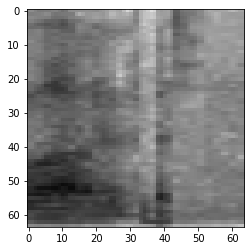

In [4]:
plt.imshow(imread('spectrograms/5_jackson_35.png'))

In [50]:
pixels = []
for i in range(df.shape[0]):
    pixels.append(imread(DATA_PATH+df['image name'][i]).ravel())
df['pixels'] = pixels

In [52]:
df['pixels'].describe().T

count                                                  1500
unique                                                 1500
top       [148, 148, 148, 145, 145, 145, 135, 135, 135, ...
freq                                                      1
Name: pixels, dtype: object

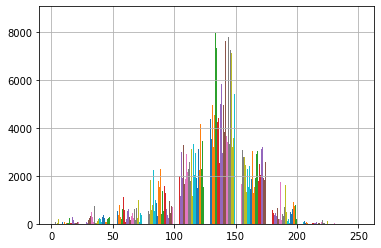

In [58]:
df['pixels'].hist()

# Pre Processing

In [5]:
im_gen = ImageDataGenerator(rescale=1./255.,validation_split=0.25,)
train_data = im_gen.flow_from_dataframe(df,directory=DATA_PATH,x_col='image name', y_col='label',
                                        target_size=(64,64),seed=SEED,subset='training',
                                        batch_size=BATCH_SIZE)
val_data = im_gen.flow_from_dataframe(df,directory=DATA_PATH,x_col='image name', y_col='label',
                                        target_size=(64,64),seed=SEED,subset='validation',
                                      batch_size=BATCH_SIZE)

Found 1125 validated image filenames belonging to 10 classes.
Found 375 validated image filenames belonging to 10 classes.


# Model

In [6]:
input_ = Input(shape=(64,64,3),name='input')
layer = Conv2D(32,kernel_size=(3,3),activation='relu',name='first_conv',padding='same')(input_)
layer = Conv2D(64,kernel_size=(3,3),activation='relu',name='second_conv', padding='same')(layer)
layer = MaxPooling2D(pool_size=(2,2),padding='same',name='first_pool')(layer)
layer = Conv2D(32,kernel_size=(3,3),activation='relu',name='third_conv', padding='same')(layer)
layer = MaxPooling2D(pool_size=(2,2),padding='same',name='second_pool')(layer)
layer = Flatten()(layer)
layer = Dense(128,activation='relu',name='dense_1')(layer)
output = Dense(10,activation='softmax',name='output')(layer)
model = Model(inputs=input_,outputs=output)

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

plot_model(model,show_shapes=True,to_file='Simple Model.png')

model.summary()







_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 64, 64, 3)         0         
_________________________________________________________________
first_conv (Conv2D)          (None, 64, 64, 32)        896       
_________________________________________________________________
second_conv (Conv2D)         (None, 64, 64, 64)        18496     
_________________________________________________________________
first_pool (MaxPooling2D)    (None, 32, 32, 64)        0         
_________________________________________________________________
third_conv (Conv2D)          (None, 32, 32, 32)        18464     
_________________________________________________________________
second_pool (MaxPooling2D)   (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
____

In [7]:
ES = EarlyStopping(patience=4,restore_best_weights=True,min_delta=0.01,verbose=1)
# MC = ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.hdf5',save_best_only=True,verbose=1)

history1 = model.fit_generator(train_data,validation_data=val_data,epochs=15,
                    steps_per_epoch=1125//32,validation_steps=375//32,verbose=1,)#callbacks=[ES],)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/15





35/35 [==============================] - 24s 699ms/step - loss: 2.3322 - acc: 0.1036 - val_loss: 2.3045 - val_acc: 0.1023
Epoch 2/15
35/35 [==============================] - 20s 572ms/step - loss: 2.3020 - acc: 0.1179 - val_loss: 2.2937 - val_acc: 0.1193
Epoch 3/15
35/35 [==============================] - 22s 630ms/step - loss: 2.2810 - acc: 0.1376 - val_loss: 2.2883 - val_acc: 0.0838
Epoch 4/15
35/35 [==============================] - 22s 641ms/step - loss: 2.1067 - acc: 0.2875 - val_loss: 1.8589 - val_acc: 0.4375
Epoch 5/15
35/35 [==============================] - 23s 671ms/step - loss: 1.4913 - acc: 0.4742 - val_loss: 1.2544 - val_acc: 0.5449
Epoch 6/15
35/35 [==============================] - 23s 667ms/step - loss: 1.0615 - acc: 0.6679 - val_loss: 1.0562 - val_acc: 0.5795
Epoch 7/15
35/35 [==============================] - 24s 677ms/step - loss: 0.6885 - acc: 0.7509 - va

Model is Producing good results but Overfitting

# Leaky Relu

In [8]:
input_ = Input(shape=(64,64,3),name='input')
layer = Conv2D(32,kernel_size=(3,3),activation=LeakyReLU(alpha=0.22),name='first_conv',
               padding='same')(input_)
layer = Conv2D(64,kernel_size=(3,3),activation=LeakyReLU(alpha=0.10),name='second_conv', 
               padding='same')(layer)
layer = MaxPooling2D(pool_size=(2,2),padding='same',name='first_pool')(layer)
layer = Conv2D(32,kernel_size=(3,3),activation='relu',name='third_conv', padding='same')(layer)
layer = MaxPooling2D(pool_size=(2,2),padding='same',name='second_pool')(layer)
layer = Flatten()(layer)
layer = Dense(128,activation=LeakyReLU(alpha=0.17),name='dense_1')(layer)
output = Dense(10,activation='softmax',name='output')(layer)

model2 = Model(inputs=input_,outputs=output)

model2.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

plot_model(model2,show_shapes=True,to_file='model_with_LeakyRelu().png')

model2.summary()

/home/deshwal/anaconda3/lib/python3.7/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 64, 64, 3)         0         
_________________________________________________________________
first_conv (Conv2D)          (None, 64, 64, 32)        896       
_________________________________________________________________
second_conv (Conv2D)         (None, 64, 64, 64)        18496     
_________________________________________________________________
first_pool (MaxPooling2D)    (None, 32, 32, 64)        0         
_________________________________________________________________
third_conv (Conv2D)          (None, 32, 32, 32)        18464     
_________________________________________________________________
second_pool (MaxPooling2D)   (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
__________

In [9]:
ES = EarlyStopping(patience=4,restore_best_weights=True,min_delta=0.01,verbose=1)
# MC = ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.hdf5',save_best_only=True,verbose=1)

history2 = model2.fit_generator(train_data,validation_data=val_data,epochs=15,
                    steps_per_epoch=1125//32,validation_steps=375//32,verbose=1,)#callbacks=[ES],)

Epoch 1/15
35/35 [==============================] - 25s 707ms/step - loss: 2.4661 - acc: 0.1001 - val_loss: 2.3169 - val_acc: 0.0739
Epoch 2/15
35/35 [==============================] - 24s 682ms/step - loss: 2.3040 - acc: 0.1214 - val_loss: 2.3017 - val_acc: 0.1976
Epoch 3/15
35/35 [==============================] - 22s 616ms/step - loss: 2.2878 - acc: 0.1593 - val_loss: 2.2488 - val_acc: 0.1023
Epoch 4/15
35/35 [==============================] - 22s 642ms/step - loss: 2.1358 - acc: 0.2000 - val_loss: 1.9691 - val_acc: 0.3174
Epoch 5/15
35/35 [==============================] - 22s 642ms/step - loss: 1.5608 - acc: 0.4666 - val_loss: 1.3063 - val_acc: 0.6136
Epoch 6/15
35/35 [==============================] - 23s 668ms/step - loss: 0.9838 - acc: 0.6679 - val_loss: 1.0493 - val_acc: 0.6287
Epoch 7/15
35/35 [==============================] - 22s 617ms/step - loss: 0.6301 - acc: 0.7871 - val_loss: 0.6918 - val_acc: 0.7386
Epoch 8/15
35/35 [==============================] - 23s 666ms/step - 

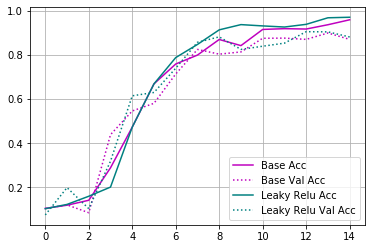

In [40]:
plot_graphs(history1,history2,'Leaky Relu')

In [45]:
t_test(history1,history2,'Leaky Relu')

There is a difference of -0.1275369888873038 between the base and Leaky Relu model mean accuracy with a p-value of 0.8994269554328733
It means there is no significance difference because of the p-value


# Dropout

In [10]:
input_ = Input(shape=(64,64,3),name='input')
layer = Conv2D(32,kernel_size=(3,3),activation='relu',name='first_conv',padding='same')(input_)
layer = Conv2D(64,kernel_size=(3,3),activation='relu',name='second_conv', padding='same')(layer)
layer = MaxPooling2D(pool_size=(2,2),padding='same',name='first_pool')(layer)
layer = Conv2D(32,kernel_size=(3,3),activation='relu',name='third_conv', padding='same')(layer)
layer = MaxPooling2D(pool_size=(3,3),padding='same',name='second_pool')(layer)
layer = Flatten()(layer)
layer = Dense(128,activation='relu',name='dense_1')(layer)
layer = Dropout(0.50)(layer)
output = Dense(10,activation='softmax',name='output')(layer)

model3 = Model(inputs=input_,outputs=output)

model3.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

plot_model(model3,show_shapes=True,to_file='model_with_Drouout.png')

model3.summary()


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 64, 64, 3)         0         
_________________________________________________________________
first_conv (Conv2D)          (None, 64, 64, 32)        896       
_________________________________________________________________
second_conv (Conv2D)         (None, 64, 64, 64)        18496     
_________________________________________________________________
first_pool (MaxPooling2D)    (None, 32, 32, 64)        0         
_________________________________________________________________
third_conv (Conv2D)          (None, 32, 32, 32)        18464     
_________________________________________________________________
second_pool (MaxPooling2D)   (None, 11, 11, 32)        0         
__________________________

In [11]:
#ES = EarlyStopping(patience=4,restore_best_weights=True,min_delta=0.01,verbose=1)
# MC = ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.hdf5',save_best_only=True,verbose=1)

history3 = model3.fit_generator(train_data,validation_data=val_data,epochs=15,
                    steps_per_epoch=1125//32,validation_steps=375//32,verbose=1,)#callbacks=[ES],)

Epoch 1/15
35/35 [==============================] - 24s 689ms/step - loss: 2.3209 - acc: 0.0982 - val_loss: 2.2993 - val_acc: 0.1317
Epoch 2/15
35/35 [==============================] - 22s 633ms/step - loss: 2.3043 - acc: 0.0929 - val_loss: 2.3017 - val_acc: 0.0511
Epoch 3/15
35/35 [==============================] - 21s 610ms/step - loss: 2.3001 - acc: 0.1071 - val_loss: 2.2852 - val_acc: 0.1617
Epoch 4/15
35/35 [==============================] - 24s 692ms/step - loss: 2.2885 - acc: 0.1307 - val_loss: 2.2458 - val_acc: 0.2216
Epoch 5/15
35/35 [==============================] - 21s 611ms/step - loss: 2.1103 - acc: 0.2286 - val_loss: 1.7232 - val_acc: 0.4659
Epoch 6/15
35/35 [==============================] - 22s 626ms/step - loss: 1.8823 - acc: 0.3418 - val_loss: 1.5886 - val_acc: 0.5210
Epoch 7/15
35/35 [==============================] - 22s 625ms/step - loss: 1.6078 - acc: 0.4107 - val_loss: 1.1351 - val_acc: 0.6364
Epoch 8/15
35/35 [==============================] - 22s 621ms/step - 

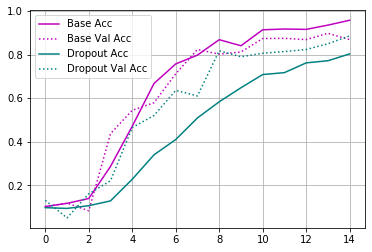

In [25]:
plot_graphs(history1,history3,'Dropout')

In [46]:
t_test(history1,history3,'Dropout')

There is a difference of 1.6757512357418172 between the base and Dropout model mean accuracy with a p-value of 0.10492029975108652
It means there is no significance difference because of the p-value


# Batch Normalization

In [12]:
input_ = Input(shape=(64,64,3),name='input')
layer = Conv2D(32,kernel_size=(3,3),activation='relu',name='first_conv',padding='same')(input_)
layer = Conv2D(64,kernel_size=(3,3),activation='relu',name='second_conv', padding='same')(layer)
layer = BatchNormalization()(layer)
layer = MaxPooling2D(pool_size=(2,2),padding='same',name='first_pool')(layer)
layer = Conv2D(32,kernel_size=(3,3),activation='relu',name='third_conv', padding='same')(layer)
layer = BatchNormalization()(layer)
layer = MaxPooling2D(pool_size=(2,2),padding='same',name='second_pool')(layer)
layer = Flatten()(layer)
layer = Dense(128,activation='relu',name='dense_1')(layer)
output = Dense(10,activation='softmax',name='output')(layer)

model4 = Model(inputs=input_,outputs=output)

model4.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

plot_model(model4,show_shapes=True, to_file='Batch Normalized.png')

model4.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 64, 64, 3)         0         
_________________________________________________________________
first_conv (Conv2D)          (None, 64, 64, 32)        896       
_________________________________________________________________
second_conv (Conv2D)         (None, 64, 64, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
first_pool (MaxPooling2D)    (None, 32, 32, 64)        0         
_________________________________________________________________
third_conv (Conv2D)          (None, 32, 32, 32)        18464     
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________

In [13]:
ES = EarlyStopping(patience=4,restore_best_weights=True,min_delta=0.01,verbose=1)
# MC = ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.hdf5',save_best_only=True,verbose=1)

history4 = model4.fit_generator(train_data,validation_data=val_data,epochs=15,
                    steps_per_epoch=1125//32,validation_steps=375//32,verbose=1)#,callbacks=[ES],)

Epoch 1/15
35/35 [==============================] - 31s 886ms/step - loss: 5.0274 - acc: 0.2501 - val_loss: 3.4204 - val_acc: 0.3011
Epoch 2/15
35/35 [==============================] - 29s 821ms/step - loss: 1.4037 - acc: 0.4857 - val_loss: 1.3639 - val_acc: 0.4943
Epoch 3/15
35/35 [==============================] - 30s 852ms/step - loss: 1.0702 - acc: 0.6120 - val_loss: 1.1284 - val_acc: 0.6228
Epoch 4/15
35/35 [==============================] - 28s 810ms/step - loss: 0.7443 - acc: 0.7268 - val_loss: 1.2465 - val_acc: 0.6307
Epoch 5/15
35/35 [==============================] - 28s 786ms/step - loss: 0.5691 - acc: 0.7726 - val_loss: 1.1157 - val_acc: 0.6707
Epoch 6/15
35/35 [==============================] - 28s 801ms/step - loss: 0.3839 - acc: 0.8696 - val_loss: 3.2622 - val_acc: 0.5227
Epoch 7/15
35/35 [==============================] - 27s 764ms/step - loss: 0.3562 - acc: 0.8821 - val_loss: 2.6056 - val_acc: 0.5868
Epoch 8/15
35/35 [==============================] - 29s 820ms/step - 

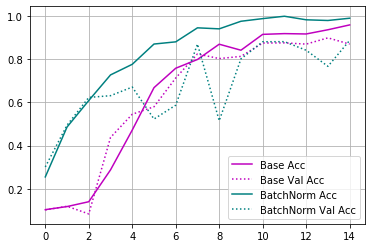

In [26]:
plot_graphs(history1,history4,'BatchNorm')

In [48]:
t_test(history1,history4,'Batch Normalization')

There is a difference of -1.758851160076341 between the base and Batch Normalization model mean accuracy with a p-value of 0.08952873044345097
It means there is no significance difference because of the p-value


# Final Model
With Relu + Leaky Relu + Dropout + Batch Normalization

In [14]:
input_ = Input(shape=(64,64,3),name='input')
layer = Conv2D(64,kernel_size=(3,3),activation='relu',name='first_conv',padding='same')(input_)
layer = Conv2D(64,kernel_size=(3,3),name='second_conv',padding='same')(layer)
layer = LeakyReLU(0.17)(layer)
layer = BatchNormalization()(layer)
layer = MaxPooling2D(pool_size=(2,2),padding='same',name='first_pool')(layer)
layer = Conv2D(32,kernel_size=(3,3),activation='relu',name='third_conv', padding='same')(layer)
layer = MaxPooling2D(pool_size=(3,3),padding='same',name='second_pool')(layer)
layer = Flatten()(layer)
layer = Dense(128,name='dense_1')(layer)
layer = LeakyReLU(0.10)(layer)
layer = Dropout(0.25)(layer)
output = Dense(10,activation='softmax',name='output')(layer)

model5 = Model(inputs=input_,outputs=output)

model5.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

plot_model(model5,show_shapes=True,to_file='final_model.png')

model5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 64, 64, 3)         0         
_________________________________________________________________
first_conv (Conv2D)          (None, 64, 64, 64)        1792      
_________________________________________________________________
second_conv (Conv2D)         (None, 64, 64, 64)        36928     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 64, 64, 64)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
first_pool (MaxPooling2D)    (None, 32, 32, 64)        0         
_________________________________________________________________
third_conv (Conv2D)          (None, 32, 32, 32)        18464     
__________

In [15]:
ES = EarlyStopping(patience=3,restore_best_weights=True,min_delta=0.01,verbose=1)
MC = ModelCheckpoint(filepath='model_weight/model.{epoch:02d}-{val_loss:.2f}.hdf5',save_best_only=True,verbose=1)

history5 = model5.fit_generator(train_data,validation_data=val_data,epochs=15,
                    steps_per_epoch=1125//32,validation_steps=375//32,verbose=1)#,callbacks=[ES,MC],)

Epoch 1/15
35/35 [==============================] - 42s 1s/step - loss: 2.3326 - acc: 0.2268 - val_loss: 2.1739 - val_acc: 0.1648
Epoch 2/15
35/35 [==============================] - 37s 1s/step - loss: 1.4613 - acc: 0.5046 - val_loss: 2.0962 - val_acc: 0.2455
Epoch 3/15
35/35 [==============================] - 39s 1s/step - loss: 0.9442 - acc: 0.6768 - val_loss: 1.1935 - val_acc: 0.6477
Epoch 4/15
35/35 [==============================] - 38s 1s/step - loss: 0.6668 - acc: 0.7762 - val_loss: 1.2668 - val_acc: 0.5808
Epoch 5/15
35/35 [==============================] - 38s 1s/step - loss: 0.4323 - acc: 0.8411 - val_loss: 0.5422 - val_acc: 0.7841
Epoch 6/15
35/35 [==============================] - 38s 1s/step - loss: 0.4357 - acc: 0.8463 - val_loss: 0.3723 - val_acc: 0.8623
Epoch 7/15
35/35 [==============================] - 39s 1s/step - loss: 0.2657 - acc: 0.9143 - val_loss: 0.6759 - val_acc: 0.8125
Epoch 8/15
35/35 [==============================] - 37s 1s/step - loss: 0.2303 - acc: 0.93

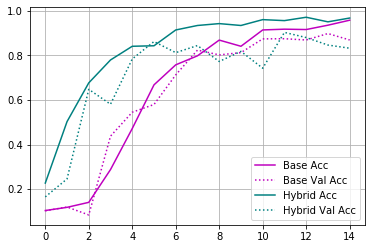

In [27]:
plot_graphs(history1,history5,'Hybrid')

In [49]:
t_test(history1,history5,'Hybrid')

There is a difference of -1.78845276960208 between the base and Hybrid model mean accuracy with a p-value of 0.08452953016330868
It means there is no significance difference because of the p-value
